# Knowledge Graph Embeddings for Ontologies

## Introduction 

This colab goes through a pipeline for applying KGE models on ontologies as desribed in our Medium post. It is split in four sections:


1. **Data** Ontology to graph, graph processing, and dataset creation.

2. **KGE Models** Defintions of custom KGE models.

3. **Training & Evaluation** Training each KGE models on each dataset for user-defined hyper-parameters.

4. **Analysis and Plotting** Plotting and analysis functions used in our experiments.

Install libraries

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install git+https://github.com/rusty1s/pytorch_geometric.git
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install networkx
!pip install py2neo
!pip install rdflib
!pip install obonet

Mount drive if your ontology folder is stored there (see below).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data

We assume as input ontologies in .obo format and use networkx to process and analyse them as graphs. Some of the graph processing functions we include are used in our experiments to create alternative datasets from the same ontology. As explained in the Medium post, for each ontology we experimented with three different versions using the following naming conventions (we use the "uberon" ontology as a running example):

1) "uberon": we keep the graph as is

2) "uberon_trans": we add the transitive closure of the "is_a" relation as a new edge type, called "is_a_trans" and add it back to the original graph

3) "uberon_only_trans": graph induced by just the transitive close of "is_a", i.e., a graph whose only edge type is "is_a_trans". 

To construct graphs versions 2 and 3 we define functions for getting the transitive closure of an edge_type and for filtering out selected edge types. In all cases, the networkx graph representation is then transformed into a PyTorch Geometric Data object whose edges are split into train, validation, and test sets (again represented as PyG Data objects). 


In [ ]:
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import obonet
from torch_geometric.transforms import RandomLinkSplit

# usefull graph processing functions

def get_edge_counts(G):

  """
  Get a dictionary with the edge count of each edge type

  G: networkx graph with edge types

  """

  edge_type_counts = {}

  # Iterate over the edges and their data
  for _, _, edge_type in G.edges:

      if edge_type not in edge_type_counts:

          edge_type_counts[edge_type] = 0

      edge_type_counts[edge_type] += 1

  return edge_type_counts

def add_transitive_closure(G, edge_type):

  """
  Adds the transitive closure of edge type = edge_type in Graph G in place.
  If the original relation type was called "rel" the added relation will be called "rel_trans"
  Note that the original is not removed.

  G: networkX graph with edge types
  edge_type: one of the edge types

  """

  is_a_edges = [(u, v, edge_t) for u, v, edge_t in G.edges if edge_t == edge_type]
  is_a_subgraph = G.edge_subgraph(is_a_edges)

  is_a_transitive_closure = nx.transitive_closure(is_a_subgraph)

  # Add the new edges from the transitive closure back into the original graph
  new_is_a_edges = [(x[0], x[1], edge_type + "_trans") for x in set(is_a_transitive_closure.edges()) - set(is_a_subgraph.edges())]
  G.add_edges_from(new_is_a_edges)

def avg_degrees_type(G, edge_type):

  """
  Calculate and print the average in-degree and out-degree
  of nodes in G with respect to the sepcified edge type.

  G: netowrkx graph with edge types.
  edge_type: one of the edge types.

  """


  in_degrees = {}
  out_degrees = {}

  for u, v, key in G.edges:

      if key == edge_type:

          if v not in in_degrees:
              in_degrees[v] = 0
          in_degrees[v] += 1

          if u not in out_degrees:
              out_degrees[u] = 0
          out_degrees[u] += 1

  avg_in_degree = sum(in_degrees.values()) / len(in_degrees)
  avg_out_degree = sum(out_degrees.values()) / len(out_degrees)

  print("Average in-degree for " + edge_type + " edge type:", avg_in_degree)
  print("Average out-degree for " + edge_type + " edge type:", avg_out_degree)

def obo_to_networkx (obo_path):

  """
  Load the ontology from a local .obo file into networkx graph.

  """
  G = obonet.read_obo(obo_path,ignore_obsolete=True)

  # Convert the ontology to a NetworkX graph

  G = nx.MultiDiGraph(G)

  # remove degenerate edges from uberon ontology
  
  if obo_path.split("/")[-1] == "uberon.obo":
    for node in list(G.nodes()):
        if not node.startswith("UBERON"):
            G.remove_node(node)

  return G

def networkx_to_pygeo (G):
  """
  Transform the networkx object to a pytorch geometic Data object without loss of edge information.

  """

  # create the mapping from node labels to integer ids

  node_id_map = {node_label: i for i, node_label in enumerate(G.nodes)}

  # create the edge_index and edge_type arrays

  edge_index = []
  edge_type = []

  for start_node, end_node, rel_type in G.edges:
      G.edges[(start_node, end_node, rel_type)]["edge_type"] = rel_type
      start_node_id = node_id_map[start_node]
      end_node_id = node_id_map[end_node]
      edge_index.append([start_node_id, end_node_id])
      edge_type.append(rel_type)

  # convert the edge_type array to integer ids

  edge_type_map = {rel_type: i for i, rel_type in enumerate(set(edge_type))}
  edge_type = [edge_type_map[rel_type] for rel_type in edge_type]

  # create the PyTorch Geometric Data object

  x = torch.zeros((len(node_id_map),)) 
  data = Data(x=x, edge_index=torch.tensor(edge_index).t().contiguous(), edge_type=torch.tensor(edge_type))

  return data, node_id_map, edge_type_map

import numpy as np

def split_data (data, train_ratio=0.8, val_ratio=0.1):

    """
    Edge based splitting of pytorch Data object.
    Outputs are used for KGE training and evaluation.

    Splits the data object into three new data objects 
    representing subgraphs of the original
    with disjoint edges, but the same number of nodes.
    Indexing is maintained across the graphs.

    test_ratio is 1 - (train_ratio + val_ratio)

    """

    num_edges = data.edge_index.shape[1]
    edge_indices = np.arange(num_edges)

    np.random.shuffle(edge_indices)

    train_size = int(train_ratio * num_edges)
    val_size = int(val_ratio * num_edges)

    train_indices = edge_indices[:train_size]
    val_indices = edge_indices[train_size:train_size + val_size]
    test_indices = edge_indices[train_size + val_size:]

    train_edge_index = data.edge_index[:, train_indices]
    val_edge_index = data.edge_index[:, val_indices]
    test_edge_index = data.edge_index[:, test_indices]

    train_edge_types = data.edge_type[train_indices]
    val_edge_types = data.edge_type[val_indices]
    test_edge_types = data.edge_type[test_indices]

    train_data = Data(x=data.x, edge_index=train_edge_index, edge_type = train_edge_types)
    val_data = Data(x=data.x, edge_index=val_edge_index, edge_type = val_edge_types)  
    test_data = Data(x=data.x, edge_index=test_edge_index, edge_type = test_edge_types)

    return train_data, val_data, test_data


Function to load the onotologies.

To use: once you downloaded the ontology obo files from their respective websites (see Medium Post) put them in a folder called "ontologies" and add them to your workspace.

Replace "onto_path" with your own.



In [ ]:

onto_path = '/content/drive/MyDrive/ontologies/'
def load_ontology_dataset (ontology, transitive_edges = [], choose_edges = False, edge_filter = []):
  #import ontology and turn to networkx graph
  obo_path = onto_path + ontology + '.obo'
  G = obo_to_networkx (obo_path)
  transitive_edge_types = transitive_edges
  #add transitive closure of chosen edge types
  for t in transitive_edge_types:
    add_transitive_closure(G, t)
  transitive_edge_types = [e + "_trans" for e in transitive_edge_types]
  # choose_edges to keep
  if choose_edges:
    filtered_edges = [(u, v, edge_t) for u, v, edge_t in G.edges if edge_t in edge_filter]
    G = G.edge_subgraph(filtered_edges)
  #create pytorch geometric data object
  data, node_dict, edge_dict = networkx_to_pygeo(G)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  data.to(device)
  # split edges to train, val, test
  train_data, val_data, test_data = split_data(data,train_ratio = 0.8, val_ratio = 0.1)
  # determine the distance types for each edge type for subsetE
  trans_keys = [edge_dict[key] for key in transitive_edge_types]
  dist_dict = {}
  dist_dict["subsumption"] = []
  dist_dict["hausdorff"] = []
  for v in edge_dict.values():
    if v in trans_keys:
      dist_dict["subsumption"].append(v)
    else: 
      dist_dict["hausdorff"].append(v)
  
  return {"G": G, "train_data" : train_data, "val_data" : val_data, "test_data" : test_data, "dist_dict" : dist_dict}




Load the ontologies and transform each to a dataset in three ways.

1. as is
2. add transitive closuse of "is_a" relation
3. include only the transitive closure

Combine all the outputs in a dictionary labeled by the ontology name (see name conventions above). Each value is another dictionary containg the train,val, test objects as well as some stats and the "dist_dict" dictionary used to tell subsetE what distance function it should use to calculate the loss for each relation type (see the implementation of the score function in the definition of SubsetE in the KGE models section).

In [ ]:
ontologies = ["cl", "go", "hp", "uberon"]
onto_datasets= {}
for o in ontologies:
  
  #add as is
  ont_dict = load_ontology_dataset(o)
  G = ont_dict["G"]
  ont_dict["num_nodes"] = G.number_of_nodes()
  ont_dict["num_edges"] = G.number_of_edges()
  ont_dict["edges_counts"] = get_edge_counts(G)
  onto_datasets[o] = ont_dict
  # add with trans closure
  o_trans = o + "_trans"
  ont_dict = load_ontology_dataset(o, transitive_edges=["is_a"])
  G = ont_dict["G"]
  ont_dict["num_nodes"] = G.number_of_nodes()
  ont_dict["num_edges"] = G.number_of_edges()
  ont_dict["edges_counts"] = get_edge_counts(G)
  onto_datasets[o_trans] = ont_dict
  # add only with trans closure
  o_trans = o + "_only_trans"
  ont_dict = load_ontology_dataset(o, transitive_edges=["is_a"],choose_edges=True, edge_filter=["is_a_trans"])
  G = ont_dict["G"]
  ont_dict["num_nodes"] = G.number_of_nodes()
  ont_dict["num_edges"] = G.number_of_edges()
  ont_dict["edges_counts"] = get_edge_counts(G)
  onto_datasets[o_trans] = ont_dict


# KGE Models

The PyG representation allows us to apply the KGE functionalities of the PyG library which center around the abstract KGEModel class (https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.kge.KGEModel.html). This class already has TransE, ComplexE, and DistMult as instances but also allows one to easily create custom KGE models. We illustrate this with two examples. 

The first one is a loose implementation of TransR, where we have assumed for simplity that the node and relation embeddings have the same dimension (so the rel_W matrix of each relation is square). 

The second one is SubsetE, an original method we developed with the aim of leveraging the class hierarchy of nodes in ontology graphs based on the "is a" relation (for example: dog - is a -> mammal). Roughly, the idea is to represent node embeddings (i.e. ontology concepts) as sets of points (vs single points) in H-dimensional space delimiting a region between them which respesents the "range" of the said concept. We then use a loss function that forces children of the is a relation to be repsented by regions that are contained in the region of their parent concepts (so the embedding region of "dog" should be a subset of the embedding region of "pet" which should in turn be contained in the region of "mammal"). For reasons explained in detail in the blog post this method proved ineffective largely due to the difficulty of balancing opposing loss objectives without making the training unstable. However, for future work and experimentation we include our working implementation below, along with all the distance functions we experimented with to construct loss functions.

Our implementation of TransR

Restriction: for ease of use and since we are only interested in "big_picture" qualitative results we assume that the embedding and relation space have the same dimension i.e. "hidden_channels". 


In [ ]:
import math
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Embedding
from torch_geometric.nn.kge import KGEModel


class TransR(KGEModel):
    def __init__(
        self,
        num_nodes: int,
        num_relations: int,
        hidden_channels: int,
        margin: float = 1.0,
        p_norm: float = 1.0,
        sparse: bool = False,
    ):
        self.p_norm = p_norm
        self.margin = margin

        super().__init__(num_nodes, num_relations, hidden_channels, sparse)

        self.node_emb = Embedding(num_nodes, hidden_channels, sparse=sparse)
        self.rel_emb = Embedding(num_relations, hidden_channels, sparse=sparse)
        
        self.rel_W = Embedding(num_relations, hidden_channels * hidden_channels, sparse=sparse)
        
      
        self.reset_parameters()

    def reset_parameters(self):
        bound = 6. / math.sqrt(self.hidden_channels)
        torch.nn.init.uniform_(self.node_emb.weight, -bound, bound)
        torch.nn.init.uniform_(self.rel_emb.weight, -bound, bound)
        F.normalize(self.rel_emb.weight.data, p=self.p_norm, dim=-1,
                    out=self.rel_emb.weight.data)

    def forward(
        self,
        head_index: Tensor,
        rel_type: Tensor,
        tail_index: Tensor,
    ) -> Tensor:

        head = self.node_emb(head_index)
        tail = self.node_emb(tail_index)
        rel = self.rel_emb(rel_type)
        rel_W = self.rel_W(rel_type)
        rel_W = rel_W.view(-1, self.hidden_channels, self.hidden_channels) 
        rel_W = rel_W[rel_type]

        # Perform batched matrix multiplication

        head = F.normalize(head, p=self.p_norm, dim=-1)
        tail = F.normalize(tail, p=self.p_norm, dim=-1)

        head = torch.bmm(rel_W, head.unsqueeze(-1)).squeeze(-1)
        tail = torch.bmm(rel_W, tail.unsqueeze(-1)).squeeze(-1)



        head = F.normalize(head, p=self.p_norm, dim=-1)
        tail = F.normalize(tail, p=self.p_norm, dim=-1)


        # Calculate *negative* TransR norm:
        return -((head + rel) - tail).norm(p=self.p_norm, dim=-1)

    def loss(
        self,
        head_index: Tensor,
        rel_type: Tensor,
        tail_index: Tensor,
    ) -> Tensor:

        pos_score = self(head_index, rel_type, tail_index)
        neg_score = self(*self.random_sample(head_index, rel_type, tail_index))

        return F.margin_ranking_loss(
            pos_score,
            neg_score,
            target=torch.ones_like(pos_score),
            margin=self.margin,
        )

Utility, distance, and normalization/potential functions for defining SubsetE. Note that not all of them are used in the defintion that comes after. See the function descriptions and the Medium post for the role of each.

In [ ]:
# loss functions for subsetE


def can_broadcast(s, t):
    """Given tuples/lists s and t, returns iff tensors of size s and t can be broadcasted,
       i.e. len(s) = len(t) and s[i] == t[i] unless s[i] == 1 or t[i] == 1.
    """
    if len(s) != len(t):
        return False
    for i in range(len(s)):
        if s[i] != 1 and t[i] != 1 and s[i] != t[i]:
            return False
    return True

import torch


def gravity_distance(A,B):


  center_B = B.mean(dim=1)

  # detach the center of the parent node so that it does not get destabilized
  center_B = center_B.detach()

  # Calculate the Euclidean distances between all points in A and the center of B
  squared_diffs = (A - center_B.unsqueeze(1))**2
  squared_distances = squared_diffs.sum(dim=-1)
  distances = torch.sqrt(squared_distances)

  # Calculate the average distance for each set of points in A from the center of B
  average_distances = distances.mean(dim=-1)

  return average_distances

def min_distance(x, y, p = 2):
  """
  Given two finite subsets x,y of R^d, returns their L^p distance:
  Supposing that x = {x_1, ... x_m}
  and y = {y_1, ... y_n}, where x_i,y_j are in R^d, we have 
  min_distance(x,y) = min_{i,j} ||x_i-y_j||_p.

  x and y are tensors of shape (S, *, d), where * is the size of the 
  appropriate sets, and where S is an arbitrary tuple (parallelizing the computation).
  p is the norm we are using.

  Returns a tensor of shape S.
  """
  assert(can_broadcast(x.size()[:-2], y.size()[:-2]))
  assert(x.size()[-1] == y.size()[-1])

  x_expand = x[..., None, :, :]
  y_expand = y[..., :, None, :]
  pairwise_dists = torch.norm(x_expand - y_expand, p, dim = -1)
  min_dist = torch.amin(pairwise_dists, dim = [-2,-1])

  return min_dist

def subsumption_distance(x, y, p = None):
  """
  Given two finite subsets x,y of R^d, returns their subsumption distance, 
  using distance function dist. Supposing that x = {x_1, ... x_m}
  and y = {y_1, ... y_n}, where x_i,y_j are in R^d, we have 
  set_distance(x,y) = max_{i} set_distance({x_i}, y)

  x and y are tensors of shape (S, *, d), where * is the size of the 
  appropriate sets, and where S is arbitrary (parallelizing the computation).
  p is the norm we are using. Supports array broadcasting.
  """

  assert(can_broadcast(x.size()[:-2], y.size()[:-2]))
  assert(x.size()[-1] == y.size()[-1])

  x_expand = x[..., :, None, :]
  y_expand = y[..., None, :, :]
  
  #compute set distance of each point of x to all of y
  x_point_dists = min_distance(x_expand, y_expand, p)

  #take maximum of above distances
  subsumption_dist = torch.amax(x_point_dists, dim = -1)

  return subsumption_dist

def hausdorff_distance(x, y, p = 2):
  """
  Given two finite subsets x,y of R^d, returns their Hausdorff distance, 
  using distance function dist. Supposing that x = {x_1, ... x_m}
  and y = {y_1, ... y_n}, where x_i,y_j are in R^d, we have 
  set_distance(x,y) = max(subsumption_distance(x,y), subsumption_distance(y,x))

  x and y are tensors of shape (S, *, d), where * is the size of the 
  appropriate sets, and where S is arbitrary (parallelizing the computation).
  p is the norm we are using. Supports array broadcasting.
  """

  assert(can_broadcast(x.size()[:-2], y.size()[:-2]))
  assert(x.size()[-1] == y.size()[-1])

  return torch.maximum(subsumption_distance(x,y), subsumption_distance(y,x))

def set_distance(x, y, dist_type = "hausdorff", p = 2):

    """
    Given two finite subsets x,y of R^d, returns their distance.
    The type of distance is selected in dist_type. The norm used 
    for calculations is the Lp norm. THis is just another way to call
    the above distance functions.

    x and y are tensors of shape (S, *, d), where * is the size of the 
    appropriate sets, and where S is arbitrary (parallelizing the computation).
    p is the norm we are using. Supports array broadcasting.
    """

    if dist_type == "minimum":
        return min_distance(x, y, p = 2)

    elif dist_type == "subsumption":
        return subsumption_distance(x, y, p = 2)

    elif dist_type == "hausdorff":
        return hausdorff_distance(x, y, p = 2)
    elif dist_type == "gravity":
        return gravity_distance(x,y)

    else:
        raise NotImplementedError("Not a valid set distance type!")

def potential(x, p = 2, pow = 2, C = 1/2):
    """
    Given a finite subset x of R^d, returns a potential
    which is high if the points are far apart from one another,
    and is 0 iff the points are all the same.

    Input: Tensor x of shape (S, k, d). k is the size of the subset
    and d is the dimension of the embedding space. S is arbitrary,
    and allows this function to be computed in parallel.
    """

    x_i = x[..., :, None, :]
    x_j = x[..., None, :, :]

    dists = torch.norm(x_i - x_j, p = p, dim = -1)

    powdists = torch.pow(dists, pow)

    #set diagonal elements to 0 
    # diag = torch.diagonal(powdists, dim1 = -2, dim2 = -1)
    # diag[True] = 0

    sumpowdists = torch.sum(powdists, dim = (-2,-1))

    return 1/2 * C * sumpowdists

def sum_of_sqs_potential(x):
    """
    Given a finite subset x of R^d, returns the sum of squares potential.

    Input: Tensor x of shape (S, k, d). k is the size of the subset
    and d is the dimension of the embedding space. S is arbitrary,
    and allows this function to be computed in parallel.
    """

    return potential(x, p = 2, pow = 2, C = 1/2)

def newton_potential(x):
    """
    Given a finite subset x of R^d, returns (un-normalized) newton potential.
    Asserts that d >= 3 to avoid computing log.

    Input: Tensor x of shape (S, k, d). k is the size of the subset
    and d is the dimension of the embedding space. S is arbitrary,
    and allows this function to be computed in parallel.
    """

    emb_dim = x.shape[-1] #dimension of embeddings

    assert emb_dim >= 3, "embedding dimension must be at least 3 for newton potential"

    return potential(x, p = 2, pow = 2 - emb_dim, C = -1)


def expand_last_dimension(x, last_dim):
    """
    Given a Tensor of shape (S, d), where S is an arbitrary tuple. Asserts that
    last_dim divides d. Returns x reshaped into a Tensor of shape
    (S, d/last_dim, last_dim). 

    Example: if S = (), d = 4, last_dim = 2, 
    and x = [1, 2, 3, 4], returns [[1, 2],
                                    3, 4]]
    
    """
    S = x.shape[:-1]
    d = x.shape[-1]
    assert d % last_dim == 0, "invalid operation, last dimension can not be expanded into this shape"

    return torch.reshape(x, S + (d//last_dim, last_dim))

def barrier_potential(x, p = 2):
    """
    Given a finite subset x of R^d, returns a potential
    which incentivizes points to lie in the unit Lp  ball

    Input: Tensor x of shape (S, k, d). k is the size of the subset
    and d is the dimension of the embedding space. S is arbitrary,
    and allows this function to be computed in parallel.
    """

    R = torch.nn.ReLU()
    return torch.sum(R(torch.norm(x, dim = -1, p = 2) - 1), dim = -1)



SubsetE defintion using the KGE model class. The comments provide some guidance as to functionality but for the big picture refer to the mathematical defintions of the Medium Post.

In [ ]:
import math

import torch
import torch.nn.functional as F
from torch import Tensor


from torch_geometric.nn.kge import KGEModel

class SubsetE(KGEModel):
    def __init__(
        self,
        #copied from TransE. Can remove parameters if not needed.
        num_nodes: int,
        num_relations: int,
        emb_dim: int, #embedding dimension
        dist_types: dict,
        margin: float = 1.0,
        p_norm: float = 1.0,
        pts_per_node: int = 5, #number of embedding points per node
        sparse: bool = False,
    ):
        self.emb_dim = emb_dim
        self.p_norm = p_norm
        self.margin = margin
        self.dist_types = dist_types
        self.pts_per_node = pts_per_node
        super().__init__(num_nodes, num_relations, pts_per_node * emb_dim, sparse)

        self.reset_parameters()

    def reset_parameters(self):
        bound = 6. / math.sqrt(self.hidden_channels)
        torch.nn.init.uniform_(self.node_emb.weight, -bound, bound)
        torch.nn.init.uniform_(self.rel_emb.weight, -bound, bound)
        F.normalize(self.rel_emb.weight.data, p=self.p_norm, dim=-1,
                    out=self.rel_emb.weight.data)


    def forward(
        self,
        head_index: Tensor,
        rel_type: Tensor,
        tail_index: Tensor,
    ) -> Tensor:

        #split up index based on node classes, and recursively
        #call forward for each node class. Then concatenate the results.

        outs = []

        # compute sliced head_index, rel_type, and tail_index by dist_type
        for dist_type, edge_types in self.dist_types.items():

            #check which triples have an edge type with the current dist type

            mask = torch.zeros_like(rel_type, dtype=torch.bool)
            for edge_type in edge_types:
                mask = torch.logical_or(mask, rel_type == edge_type)

            # Slice the input tensors using the boolean mask

            head_index_slice = head_index[mask]
            rel_type_slice = rel_type[mask]
            tail_index_slice = tail_index[mask]

            # Add scores of current edge type to total scores list

            outs.append(self.score(head_index_slice,
                                   rel_type_slice,
                                   tail_index_slice,
                                   dist_type))
          
        return torch.cat(outs, dim = 0) 


    def score(
        self,
        head_index: Tensor,
        rel_type: Tensor,
        tail_index: Tensor,
        dist_type
    ) -> Tensor:

        #assert dist_type in self.dist_types.keys()

        head = self.node_emb(head_index)
        rel = self.rel_emb(rel_type)
        tail = self.node_emb(tail_index)

        #reshape trans_head, tail into a hidden_channels * emb_per_node matrix 
        head = expand_last_dimension(head, self.emb_dim)
        tail = expand_last_dimension(tail, self.emb_dim)
        rel = expand_last_dimension(rel, self.emb_dim)

        #head = F.normalize(head, p=self.p_norm, dim=-1) #Question.. whether to normalize or not? or include another potential term?
        #tail = F.normalize(tail, p=self.p_norm, dim=-1)

        translated_head = head #+ rel

        return -1 * set_distance(head, tail, dist_type, p = self.p_norm)


    def loss(
        self,
        head_index: Tensor,
        rel_type: Tensor,
        tail_index: Tensor,
        print_bool = False
    ) -> Tensor:

        #calcualate negative and positive scores to compute margin loss (like other KGE methods)
        #note that unlike the positiive score distance function which depends on the edge_type
        #the negative score loss uses the same distance function for all kinds of negative edges.

        pos_score = self(head_index, rel_type, tail_index)
        neg_head_index, neg_rel_type, neg_tail_index = self.random_sample(head_index, rel_type, tail_index)
        neg_score = self.score(neg_head_index, neg_rel_type, neg_tail_index, dist_type = "subsumption")


        marg_loss = F.margin_ranking_loss(
            pos_score,
            neg_score,
            target=torch.ones_like(pos_score),
            margin=self.margin,
        )
        

        #get the embeddings to calculate ReLu "normalization" loss 
        #(also refered to as gravity as it pulls embeddigns toward the unit circle, see barrier_potential definition)
        head = self.node_emb(head_index)
        tail = self.node_emb(tail_index)
        exp_head = expand_last_dimension(head, self.emb_dim)
        exp_tail = expand_last_dimension(head, self.emb_dim)
        norm_loss = 100*(torch.sum(barrier_potential(exp_head)) + torch.sum(barrier_potential(exp_tail)))

        # calculate potential loss: penalizes an embedding when its points lie to close to each other
        # meant to counter the tendency of the embeddings to colapse to points
        potential_loss = torch.sum(sum_of_sqs_potential(exp_head)) + torch.sum(gravity_distance(exp_head, exp_head))
        potential_loss += torch.sum(sum_of_sqs_potential(exp_tail)) + torch.sum(gravity_distance(exp_tail, exp_tail))


        # combine losses

        loss = norm_loss + marg_loss + potential_loss/(100 * (self.pts_per_node)^2) 

        return loss




# Training & Evaluation

Closely based on the PyG team's example training code for KGEs (https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/kge/transe.html#TransE)

Having processed our ontologies and defined/chosen our KGE models we proceed to training each of the later on each the former, for user-specifiable hyperparameter ranges. In our own experiments, having limited time and GPU credits, we hard coded all hyperparameters based on the values used in the PyG example for training KGE models but our code directly supports hyperparameter tuning. To enable it, please replace the hard coded values in the code with the names of the loop iterators.

param_combinations_outer: should be created as the product of all parameter option lists that are not optimization over in the validation stage

param_combinations_inner: should be as the product of all parameter option lists that are optimized over in the validation stage. To incude the embedding size as a hyperparameter move it from outer to inner.


In [ ]:
import torch
import torch.optim as optim
from torch_geometric.nn import ComplEx, TransE, DistMult
import itertools
import copy


model_map = {'transE': TransE, 'transR' : TransR, 'complexE': ComplEx, "distM": DistMult}

# models and datasets and embedding size to loop over 
#(note that transR will receive more parameters than the other models for the same hidden channels)
models = list(model_map.keys())
datasets = list(onto_datasets.keys())
hidden_channels = [50]

# hyperparameters for fine-tuning
# although we hard hard coded them using the ones from the examples of the PyG team 
# hyperparameter tuning is fully functional in this script.
# Just replace the hard coded values with the variables "lr" and "batch" size of the inner loop.
# You could also move the hidden channels from outer to the inner loop to optimize over

lr_rates = [0.01]
batch_sizes = [1000]
results = []

param_combinations_outer = itertools.product(models, datasets, hidden_channels)

results = []

for my_model, my_dataset, hidden_channels in param_combinations_outer:

    print("model")
    print(my_model)
    print("dataset")
    print(my_dataset)
    print("hidden_channels")
    print(hidden_channels)

    

    best_mean_rank = float('inf')
    best_hits_at_10 = 0.0
    best_params = None
    best_model = None

    param_combinations_inner = itertools.product(lr_rates, batch_sizes)

    for lr, batch_size in param_combinations_inner:

        print("lr")
        print(lr)
        print("batch_size")
        print(batch_size)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_data = onto_datasets[my_dataset]["train_data"]
        val_data = onto_datasets[my_dataset]["val_data"]
        test_data = onto_datasets[my_dataset]["test_data"]


        model = model_map[my_model](
        num_nodes= train_data.num_nodes,
        num_relations= train_data.num_edge_types,
        hidden_channels=hidden_channels,
        sparse = False
        ).to(device)

        loader = model.loader(
            head_index=train_data.edge_index[0],
            rel_type=train_data.edge_type,
            tail_index=train_data.edge_index[1],
            batch_size=batch_size,
            shuffle=True,
        )

        optimizer_map = {
            'transE': optim.Adam(model.parameters(), lr=0.01),
            'transR': optim.Adam(model.parameters(), lr=0.01),
            'complexE': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
            'distM': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
        }
        optimizer = optimizer_map[my_model]


        def train():
            model.train()
            total_loss = total_examples = 0
            for head_index, rel_type, tail_index in loader:
                optimizer.zero_grad()
                loss = model.loss(head_index, rel_type, tail_index)
                loss.backward()
                optimizer.step()
                total_loss += float(loss) * head_index.numel()
                total_examples += head_index.numel()
            return total_loss / total_examples


        #inner loop evalaution on validation set
        @torch.no_grad()
        def test(data):
            model.eval()
            return model.test(
                head_index=data.edge_index[0],
                rel_type=data.edge_type,
                tail_index=data.edge_index[1],
                batch_size=20000,
                k=10,
            )


        for epoch in range(1, 501):
            loss = train()
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            if epoch % 250 == 0:
                mean_rank, hits = test(val_data)
                print(f'Epoch: {epoch:03d}, Val Mean Rank: {mean_rank:.2f}, '
                      f'Val Hits@10: {hits:.4f}')

        if mean_rank < best_mean_rank:
            best_mean_rank = mean_rank
            best_hits_at_10 = hits
            best_params = (lr, batch_size)
            best_model = copy.deepcopy(model)

    #evaluate best model on test set
    @torch.no_grad()
    def test(data):
        best_model.eval()
        return best_model.test(
            head_index=data.edge_index[0],
            rel_type=data.edge_type,
            tail_index=data.edge_index[1],
            batch_size=20000,
            k=10,
        )

    test_mean_rank, test_hits_at_10 = test(test_data)
    print(f'Test Mean Rank: {test_mean_rank:.2f}, Test Hits@10: {test_hits_at_10:.4f}')

    result = {
    'model': my_model,
    'dataset': my_dataset,
    "hidden_dims": hidden_channels,
    "loss": loss,
    'val_mean_rank': best_mean_rank,
    'val_hits_at_10': best_hits_at_10,
    'best_params': best_params,
    'test_mean_rank': test_mean_rank,
    'test_hits_at_10': test_hits_at_10,
    }
    results.append(result)


# Analysis

We include here all analysis and plotting functions we used for data exploration, analysis, and subsetE experimentation that are not crucial to running the ontology KGE pipeline. 

Count ontology edge counts for unprocessed ontology graphs and plot histogram.

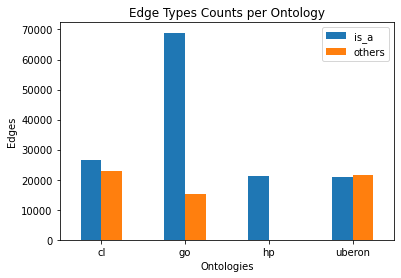

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# plot edge counts

counts = {}
for o in ontologies:
  c = {}
  edge_counts = onto_datasets[o]["edges_counts"]
  c["is_a"] = edge_counts["is_a"]
  total_edges = onto_datasets[o]["num_edges"]
  c["others"] = total_edges - c["is_a"] 
  counts[o] = c

df = pd.DataFrame(counts)
df_t = df.T

# Plot the histogram
ax = df_t.plot(kind='bar', stacked=False)
plt.title("Edge Types Counts per Ontology")
plt.xlabel("Ontologies")
plt.ylabel("Edges")
plt.xticks(rotation=0)

plt.show()

Count ontology edge counts for ontology graph versions that include the "is_a_trans" edge type and plot histogram.

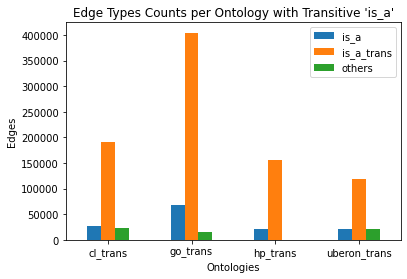

In [ ]:
import matplotlib.pyplot as plt

# plot edge counts

counts = {}
for o in [x + "_trans" for x in ontologies]:
  c = {}
  edge_counts = onto_datasets[o]["edges_counts"]
  c["is_a"] = edge_counts["is_a"]
  c["is_a_trans"] = edge_counts["is_a_trans"]
  total_edges = onto_datasets[o]["num_edges"]
  c["others"] = total_edges - (c["is_a"] + c["is_a_trans"])
  counts[o] = c

df = pd.DataFrame(counts)


# Transpose the DataFrame for easier plotting
df_t = df.T

# Plot the histogram
ax = df_t.plot(kind='bar', stacked=False)
plt.title("Edge Types Counts per Ontology with Transitive 'is_a'")
plt.xlabel("Ontologies")
plt.ylabel("Edges")
plt.xticks(rotation=0)

# Display the plot
plt.show()

We ran all models against all unprocessed ontology graphs for embedding sizes [20,50,100] to study the general perofrmance of traditional KGE methods. Since we did not include the embedding size as a hyperparameter in the inner loop (we tested each on test) we are not allowed to choose for each method the best model over all embeddings sizes, so we randomaly choose 50 to plot performance. This turns out to be okay because the relative performance of the methods is largely the same regardless of the dimension sizes chosen.

In [ ]:
results_1 = pd.read_csv(onto_path + "/results_1.csv")
df = results_1
filtered_df = df[(df['hidden_dims'] == 50)]
selected_columns_df = filtered_df[['dataset', 'model', 'test_mean_rank', 'test_hits_at_10']]
selected_columns_df.sort_values(by = "dataset", inplace = True)
df_2 = selected_columns_df.set_index("dataset")
df_2["test_mean_rank"] = [int(x) for x in df_2["test_mean_rank"]]
df_2.pivot(columns = "model", values = "test_mean_rank")

<ipython-input-325-e6fb4588ba92>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns_df.sort_values(by = "dataset", inplace = True)


model,complexE,distM,transE,transR
dataset,,,,
cl,3318,3273,740,610
go,8679,8437,4808,4142
hp,6757,6725,4812,5895
uberon,3542,3594,767,831


Basically the same code but with some adjustement to process the results of running transE and transR on the "_trans" datasets. We accidentally also run an iteration of complexE which is filtered out.

In [ ]:
results_2 = pd.read_csv(onto_path + "/results_2.csv")
df = results_2
filtered_df = df[(df['hidden_dims'] == 50) & (df['model'] != "complexE")]
selected_columns_df = filtered_df[['dataset', 'model', 'test_mean_rank', 'test_hits_at_10']]
selected_columns_df.sort_values(by = "dataset", inplace = True)
df_2 = selected_columns_df.set_index("dataset")
df_2["test_mean_rank"] = [int(x) for x in df_2["test_mean_rank"]]
df_2 = df_2.loc[['cl_only_trans', 'cl_trans', 'go_only_trans', 'go_trans',
       'hp_only_trans', 'hp_trans', 'uberon_only_trans',
       'uberon_trans']]
df_2.pivot(columns = "model", values = "test_mean_rank")

<ipython-input-323-b03c574efa15>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns_df.sort_values(by = "dataset", inplace = True)


model,transE,transR
dataset,,
cl_only_trans,70,30
cl_trans,131,237
go_only_trans,301,84
go_trans,422,194
hp_only_trans,70,34
hp_trans,123,42
uberon_only_trans,119,71
uberon_trans,152,178


Plotting function used to plot the mini graphs of the uberon ontology which we used to experiment with subsetE in order to understand its training behaviour (shown in Medium post).

In [ ]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')

nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=20, edge_color='black')

plt.show()

Plotting functions used to plot the embeddings obtained from running subsetE on these small graphs. For these examples we used 3 points in 2D space, i.e., flat triangles.

In [ ]:
import matplotlib.pyplot as plt

points = expand_last_dimension(model.node_emb.weight, 2).cpu()
cmap = plt.cm.get_cmap('viridis', len(points))
fig, ax = plt.subplots()
for i, set_points in enumerate(points):

    x = set_points[:, 0].detach().numpy()
    y = set_points[:, 1].detach().numpy()
    color = cmap(i)
    ax.scatter(x, y, color=color)
    
    ax.plot(x[[0, 1]], y[[0, 1]], linestyle='-', color=color)
    ax.plot(x[[1, 2]], y[[1, 2]], linestyle='-', color=color)
    ax.plot(x[[2, 0]], y[[2, 0]], linestyle='-', color=color)
    
    ax.text(x.mean(), y.mean(), f"{i}", fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Points in 2D Space')

plt.show()

